<a href="https://colab.research.google.com/github/ckChef/lstm-ECG-classifier/blob/main/lstm_ECG_classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 이용한 심전도 데이터 상의 부정맥 신호 인식

## module import

In [ ]:
# 구글드라이브 데이터 접속 관련
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Mounted at /content/drive


## 학습데이터 셋 로드

In [ ]:
test_data = pd.read_csv("/content/drive/MyDrive/딥러닝_미팅자료/21.02.15 미팅/ECG dataset/mitbih_test.csv")
train_data = pd.read_csv("/content/drive/MyDrive/딥러닝_미팅자료/21.02.15 미팅/ECG dataset/mitbih_train.csv")

9.779411554336547852e-01       0.960114
9.264705777168273926e-01       0.863248
6.813725233078002930e-01       0.461538
2.450980395078659058e-01       0.196581
1.544117629528045654e-01       0.094017
                                 ...   
0.000000000000000000e+00.83    0.000000
0.000000000000000000e+00.84    0.000000
0.000000000000000000e+00.85    0.000000
0.000000000000000000e+00.86    0.000000
0.000000000000000000e+00.87    0.000000
Name: 0, Length: 187, dtype: float64


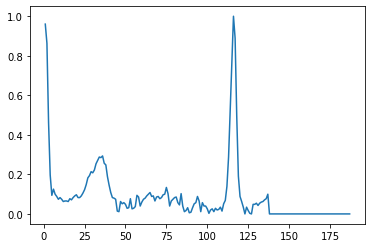

In [ ]:
sample = train_data.iloc[0][0:-1]
print(sample)

x_range = [i for i in range(1, 188)]
plt.plot(x_range, sample)
# plt.xticks([i for i in range(1,187, 20)])
# ax = plt.axes()
# ax.xaxis.set_major_locator(ticker.MultipleLocator(40))
plt.show()

## DataLoader 정의

In [ ]:
class csvDataSet(Dataset):
    def __init__(self, csv_data):
        self.x_data = csv_data.iloc[:, 0:-1]
        self.y_data = csv_data.iloc[:, -1]

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, index):
        x = torch.FloatTensor(self.x_data.iloc[index])
        y = torch.FloatTensor([self.y_data[index]])

        return x, y

In [ ]:
train_batch_size = 256
test_batch_size = 2

train_dataset = csvDataSet(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True, num_workers=2)

test_dataset = csvDataSet(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=True)

In [ ]:
class_dist = np.zeros(5)
print(len(train_data))
for i in range(len(train_data)):
    class_num = int(train_data.iloc[i][-1])
    class_dist[class_num] += 1
class_dist

87553


array([72470.,  2223.,  5788.,   641.,  6431.])

In [ ]:
test_dist = np.zeros(5)
print(len(test_data))
for i in range(len(test_data)):
    class_num = int(test_data.iloc[i][-1])
    test_dist[class_num] += 1
test_dist

21891


array([18117.,   556.,  1448.,   162.,  1608.])

## 신경망 정의

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class EcgRnn(nn.Module):
    def __init__(self):
        super(EcgRnn, self).__init__()

        self.sm = nn.Softmax(dim=1)

        self.input_size = 1
        self.hidden_size = 5
        self.num_layers = 3
        self.batch_first = True
        self.bidirectional = True
        self.batch_size = train_batch_size

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=self.batch_first,
            bidirectional=self.bidirectional,
        ).to(device)

        # 10개의 노드 출력을 5개로 압축
        self.fc = nn.Sequential(
            nn.Linear(in_features=(self.hidden_size * (self.bidirectional+1)), out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=5)
        ).to(device)

    def init_hidden_cell(self):
        hidden = torch.zeros(self.num_layers * (self.bidirectional+1), self.batch_size, self.hidden_size).to(device)
        cell = torch.zeros(self.num_layers * (self.bidirectional+1), self.batch_size, self.hidden_size).to(device)

        return hidden, cell

    def forward(self, input_, hidden, cell):
        output, (hidden_, cell_) = self.lstm(input_, (hidden, cell))
        # print(3, output.shape)

        last_output = output[:, -1, :]
        # print(4, last_output.shape)

        output = self.fc(last_output)
        # print(5, output.shape)

        # output = self.sm(output)

        return output

## 학습 진행

서버 cpu:  Intel(R) Xeon(R) 
서버 gpu:  Tesla T4  
사용 코어: cuda:0
epoch : 0/100 loss : total_loss : 250.71295166015625
epoch : 1/100 loss : total_loss : 223.87347412109375
epoch : 2/100 loss : total_loss : 222.8818359375
epoch : 3/100 loss : total_loss : 222.30467224121094
epoch : 4/100 loss : total_loss : 219.3633270263672
epoch : 5/100 loss : total_loss : 218.21932983398438
epoch : 6/100 loss : total_loss : 217.12054443359375
epoch : 7/100 loss : total_loss : 216.27639770507812
epoch : 8/100 loss : total_loss : 216.27059936523438
epoch : 9/100 loss : total_loss : 216.3013458251953
epoch : 10/100 loss : total_loss : 216.03973388671875
epoch : 11/100 loss : total_loss : 216.10406494140625
epoch : 12/100 loss : total_loss : 216.0977020263672
epoch : 13/100 loss : total_loss : 216.05355834960938
epoch : 14/100 loss : total_loss : 215.82876586914062
epoch : 15/100 loss : total_loss : 215.8498077392578
epoch : 16/100 loss : total_loss : 215.8773651123047
epoch : 17/100 loss : total_loss : 215.5

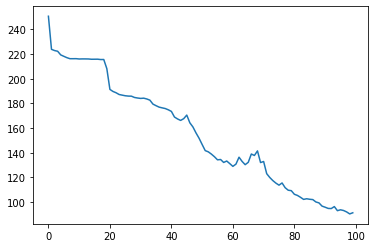

In [ ]:
# 서버 cpu 확인
cpu_list = !cat /proc/cpuinfo
print("서버 cpu: ", cpu_list[4][13:30])

# 서버 gpu 확인
gpu_list = !nvidia-smi
print("서버 gpu: ", gpu_list[8][7:17])

# 텐서 올려서 사용하는 gpu 코어 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(f"사용 코어: {device}")


# 신경망 클래스 인스턴스 생성
ecgrnn = EcgRnn()

# 손실함수와 최적화함수 정의
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(ecgrnn.parameters(), lr=0.001)

# 학습 진행
epoch = 100
loss_arr = []
for i in range(epoch):
    total_loss = 0
    for index, samples in enumerate(train_dataloader):
        # 기울기 계산 전에 누적 된 기울기 초기화
        optimizer.zero_grad()

        # smaples : (sequence_data, label)로 구성됨
        seq_data = samples[0]
        batch_size = seq_data.shape[0]
        seq_len = seq_data.shape[1]

        label = samples[1].long().to(device)
        label = label.view(batch_size, )

        # lstm에서 hidden, cell의 초깃값
        hidden, cell = ecgrnn.init_hidden_cell()

        # ==================== 신경망에 데이터 순전파 ==========================
        # pytorch에서 rnn, lstm, gru의 input은 [sequence length, batch_size, input_size]여야 한다
        # 이 때 만약 rnn의 신경망의 정의에서 batch_first 옵션을 True로 설정했다면
        # input은 [batch_size, seq_len, input_size]가 된다.

        # 이 때, input size란 input으로 들어오는 각 데이터의 차원의 의미이다. 만약 abcd를 원 핫 인코딩
        # 했다면 sequence length는 4이고 input size도 4이다.
        # 하지만 정수 인코딩으로 a = 1, b = 2, c = 3, d = 4로 인코딩 했다면
        # sequence length는 4이나 input size는 1이 되게 된다. 여기서는 input size가 1이다.

        # seq_data는 원래 input size 차원이 없는 torch.Size([100, 187]) [batch_size, seq_len] 형태인데
        # 이를 lstm에 입력값으로 사용하기 위해 input_size 차원의 값 1을 추가한다
        input_ = seq_data.unsqueeze(2).to(device)

        # print(1, seq_data.shape)
        # print(2, input_.shape)

        # 모델의 순전파를 거친 출력 값
        output = ecgrnn(input_, hidden, cell)

        loss = loss_func(output, label)
        total_loss += loss
        loss.backward()
        optimizer.step()

    print(f"epoch : {i}/{epoch} loss : total_loss : {total_loss}")
    loss_arr.append(total_loss.cpu().detach().numpy())

plt.plot(loss_arr)
plt.show()

## 신경망 성능 테스트

In [ ]:
# pytorch의 tensor 객체는 순전파 과정에서 자동적으로 기울기를 계산하고, 이를
# 이후의 역전파 과정에서 사용한다. 하지만 학습이 아닌 모델 성능을 검증하기 위해
# 순전파를 시킨다면 이러한 기울기 계산이 필요 없기 때문에 with torch.no_grad()구문으로
# 기울기 계산 없이 순전파를 수행한다.
with torch.no_grad():
    sm = nn.Softmax(dim=1)
    hidden, cell = ecgrnn.init_hidden_cell()

    data_cnt = 0
    score = 0
    for index, samples in enumerate(test_dataloader):
        seq_data = samples[0]
        batch_size = seq_data.shape[0]

        data_cnt += batch_size
        ecgrnn.batch_size = batch_size
        seq_len = seq_data.shape[1]

        label = samples[1].long().to(device)
        label = label.view(batch_size, )

        input_ = seq_data.unsqueeze(2).to(device)

        output = ecgrnn(input_, hidden, cell)
        sm_output = sm(output)

        for batch in range(batch_size):
            one_seq = sm_output[batch, :]
            max_value, max_index = torch.max(one_seq, 0)

            if max_index.item() == label[batch].item():
                score += 1

    print(f"맞춘 수 : {score}/{data_cnt}")
    print(f"accuracy : {round(score*100/data_cnt, 3)}%")


맞춘 수 : 20177/21890
accuracy : 92.175%
